# Analysis of Harry Potter Books using Natural Language Processing

#### Importing the necessary libraries

In [2]:
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
%config InlineBackend.figure_format='retina'
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import pyLDAvis.sklearn
import concurrent.futures
from datetime import datetime

#### Opening the text files and appending each book into a seperate list

In [3]:
H1 = []
H2 = []
H3 = []
H4 = []
H5 = []
H6 = []
H7 = []

f1 = open('/Users/akashbhoite/Datasets/(Book I) Harry Potter and the Sorcerer_s Stone.txt')
f2 = open('/Users/akashbhoite/Datasets/(Book II) Harry Potter and the Chamber of Secrets.txt')
f3 =  open('/Users/akashbhoite/Datasets/(Book III) Harry Potter and the Prisoner of Azkaban.txt')
f4 =  open('/Users/akashbhoite/Datasets/(Book IV) Harry Potter and the Goblet of Fire.txt')
f5 =  open('/Users/akashbhoite/Datasets/(Book V) Harry Potter and the Order of the Phoenix.txt')
f6 =  open('/Users/akashbhoite/Datasets/(Book VI) Harry Potter and the Half-Blood Prince.txt')
f7 =  open('/Users/akashbhoite/Datasets/(Book VII) Harry Potter and the Deathly Hallows.txt')
            
for line in f1:
    inner = line.strip().split()
    H1.append(inner)
        
for line in f2:
    inner = line.strip().split()
    H2.append(inner)
        
for line in f3:
    inner = line.strip().split()
    H3.append(inner)
    
for line in f4:
    inner = line.strip().split()
    H4.append(inner)
        
for line in f5:
    inner = line.strip().split()
    H5.append(inner)
        
for line in f6:
    inner = line.strip().split()
    H6.append(inner)

for line in f7:
    inner = line.strip().split()
    H7.append(inner)

In [4]:
H1 = [item for items in H1 for item in items]
H2 = [item for items in H2 for item in items]
H3 = [item for items in H3 for item in items]
H4 = [item for items in H4 for item in items]
H5 = [item for items in H5 for item in items]
H6 = [item for items in H6 for item in items]
H7 = [item for items in H7 for item in items]

#### Adding a few more context based stop words to the stopwords list

In [21]:
more_stp_words = ['harry','potter','mr','mrs','an','am','said','dont','like','dint','know','ive','got'
                 ,'could','see','havent','im','going','looked','through','tell','yeh',
                 'go','back','get','yer','would','never','seen','something','else','next','day','years'
                 ,'didnt','look','thousand','one','ever','even','though','although','every','time','make','sure'
                 ,'told','minutes','minute','hour','where','else','no','oh','ten','year','front','door','wandering','nine',
                 'ten','points','fifty','hundred','twenty','gotten','fell','asleep','yes','trying','find','one','two','three'
                 ,'four','thirteen','clock','give','us','youd','expect','picked','lived','number','twice','youknowwho','think',
                  'hed','harrys','well','around']
stop_words.extend(more_stp_words)

#### Defining the necessary functions for cleaning the text, tokenizing, removing stop words, creating word clouds, sentiment analyzer, topic modelling using LDA

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = " ".join(text)
    text = text.lower()
    text = text.strip()
    text = re.sub('\[.*?\]’', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.replace("’","")
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
        
    return text

<>:6: DeprecationWarning: invalid escape sequence \[
<>:8: DeprecationWarning: invalid escape sequence \w
<>:6: DeprecationWarning: invalid escape sequence \[
<>:8: DeprecationWarning: invalid escape sequence \w
<ipython-input-6-c643f6d55076>:6: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]’', '', text)
<ipython-input-6-c643f6d55076>:8: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', '', text)


In [7]:
def final_clean(texts):
    toks = word_tokenize(texts)
    stp = [word for word in toks if word not in stop_words]
    #stpr = ' '.join(stp)
    return stp

In [89]:
def ngram(text,grams):    
    n_grams_list = []    
    count = 0    
    for token in text[:len(text)-grams+1]:       
        #n_grams_list.append(text[count:count+grams])      
        n_grams_list.append(text[count]+' '+text[count+grams-1])        
        count=count+1      
    return n_grams_list

In [9]:
def most_common(lst, num):
    
    data = Counter(lst)    
    common = data.most_common(num)    
    top_comm = []    
    for i in range (0, num):        
        top_comm.append (common [i][0])    
    return top_comm

In [10]:
def chunk_replacement(chunk_list, text):
    """    Connects words chunks in a text by joining them with an underscore.  
    :param chunk_list: word chunks    
    :type chunk_list: list of strings/ngrams   
    :param text: text    
    :type text: string    :return: text with underscored chunks    :type: string    """ 
    text = ' '.join(text)
    for chunk in chunk_list:
            text = text.replace(chunk, chunk.replace(' ', '_'))    
    return text

In [11]:
def show_wordcloud(data):
    data = ' '.join(data)
    wc = WordCloud(background_color="white", colormap="viridis",
               max_font_size=150, random_state=42,max_words=4000)
    wc.generate(data)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()

In [12]:
def sentiment_analyzer(data,bookname):
    analyzer = SentimentIntensityAnalyzer()
    # vader needs strings as input. Transforming the list into string
    data_str = ' '.join(data)
    vad_sentiment = analyzer.polarity_scores(data_str)
    pos = vad_sentiment ['pos']
    neg = vad_sentiment ['neg']
    neu = vad_sentiment ['neu']
    print ('\nThe following is the distribution of the sentiment for the file -',bookname)
    print ('\n--- It is positive for', '{:.1%}'.format(pos))
    print ('\n--- It is negative for', '{:.1%}'.format(neg))
    print ('\n--- It is neutral for', '{:.1%}'.format(neu), '\n')

In [33]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):    
    for idx, topic in enumerate(model.components_):        
        print("Topic %d:" % (idx))        
        print([(vectorizer.get_feature_names()[i], topic[i])                        
               for i in topic.argsort()[:-top_n - 1:-1]])
        print('\n')

In [20]:
book1 = '(Book I) Harry Potter and the Sorcerer_s Stone'
book2 = '(Book II) Harry Potter and the Chamber of Secrets'
book3 = '(Book III) Harry Potter and the Prisoner of Azkaban'
book4 = '(Book IV) Harry Potter and the Goblet of Fire'
book5 = '(Book V) Harry Potter and the Order of the Phoenix'
book6 = '(Book VI) Harry Potter and the Half-Blood Prince'
book7 = '(Book VII) Harry Potter and the Deathly Hallows'

In [16]:
text_file = book1
stp_file = stop_words
word_min_len = 2
num_topics = 5

In [56]:
H1_clean1 = clean_text(H1)
H2_clean1 = clean_text(H2)
H3_clean1 = clean_text(H3)
H4_clean1 = clean_text(H4)
H5_clean1 = clean_text(H5)
H6_clean1 = clean_text(H6)
H7_clean1 = clean_text(H7)

In [57]:
H1_clean = final_clean(H1_clean1)
H2_clean = final_clean(H2_clean1)
H3_clean = final_clean(H3_clean1)
H4_clean = final_clean(H4_clean1)
H5_clean = final_clean(H5_clean1)
H6_clean = final_clean(H6_clean1)
H7_clean = final_clean(H7_clean1)

In [90]:
H1_bigrams = ngram(H1_clean,2)
H2_bigrams = ngram(H2_clean,2)
H3_bigrams = ngram(H3_clean,2)
H4_bigrams = ngram(H4_clean,2)
H5_bigrams = ngram(H5_clean,2)
H6_bigrams = ngram(H6_clean,2)
H7_bigrams = ngram(H7_clean,2)

In [91]:
H1_tri_grams = ngram(H1_clean,3)
H2_tri_grams = ngram(H2_clean,3)
H3_tri_grams = ngram(H3_clean,3)
H4_tri_grams = ngram(H4_clean,3)
H5_tri_grams = ngram(H5_clean,3)
H6_tri_grams = ngram(H6_clean,3)
H7_tri_grams = ngram(H7_clean,3)

In [98]:
#Top 10 bigrams from each of the books
H1_bigrams_10 = most_common(H1_bigrams,10)
H2_bigrams_10 = most_common(H2_bigrams,10)
H3_bigrams_10 = most_common(H3_bigrams,10)
H4_bigrams_10 = most_common(H4_bigrams,10)
H5_bigrams_10 = most_common(H5_bigrams,10)
H6_bigrams_10 = most_common(H6_bigrams,10)
H7_bigrams_10 = most_common(H7_bigrams,10)

In [99]:
print('The top 10 bigrams for Book 1 are: \n',H1_bigrams_10,'\n')
print('The top 10 bigrams for Book 2 are: \n',H2_bigrams_10,'\n')
print('The top 10 bigrams for Book 3 are: \n',H3_bigrams_10,'\n')
print('The top 10 bigrams for Book 4 are: \n',H4_bigrams_10,'\n')
print('The top 10 bigrams for Book 5 are: \n',H5_bigrams_10,'\n')
print('The top 10 bigrams for Book 6 are: \n',H6_bigrams_10,'\n')
print('The top 10 bigrams for Book 7 are: \n',H7_bigrams_10,'\n')

The top 10 bigrams for Book 1 are: 
 ['uncle vernon', 'professor mcgonagall', 'aunt petunia', 'ron hermione', 'professor dumbledore', 'common room', 'professor quirrell', 'crabbe goyle', 'privet drive', 'fred george'] 

The top 10 bigrams for Book 2 are: 
 ['professor mcgonagall', 'ron hermione', 'chamber secrets', 'fred george', 'uncle vernon', 'nearly headless', 'headless nick', 'gilderoy lockhart', 'madam pomfrey', 'common room'] 

The top 10 bigrams for Book 3 are: 
 ['ron hermione', 'professor lupin', 'professor mcgonagall', 'professor trelawney', 'uncle vernon', 'sirius black', 'aunt marge', 'common room', 'madam pomfrey', 'crabbe goyle'] 

The top 10 bigrams for Book 4 are: 
 ['ron hermione', 'madame maxime', 'professor mcgonagall', 'fred george', 'rita skeeter', 'uncle vernon', 'death eaters', 'great hall', 'world cup', 'ludo bagman'] 

The top 10 bigrams for Book 5 are: 
 ['uncle vernon', 'aunt petunia', 'privet drive', 'ministry magic', 'uncle vernons', 'little whinging', 'ro

In [97]:
#Replacing single words for the top 10 bigrams 
H1_chunk = chunk_replacement(H1_bigrams_10,H1_clean)
H2_chunk = chunk_replacement(H2_bigrams_10,H2_clean)
H3_chunk = chunk_replacement(H3_bigrams_10,H3_clean)
H4_chunk = chunk_replacement(H4_bigrams_10,H4_clean)
H5_chunk = chunk_replacement(H5_bigrams_10,H5_clean)
H6_chunk = chunk_replacement(H6_bigrams_10,H6_clean)
H7_chunk = chunk_replacement(H7_bigrams_10,H7_clean)

In [29]:
sentiment_analyzer(H1_clean,book1)
print('\n')
sentiment_analyzer(H2_clean,book2)
print('\n')
sentiment_analyzer(H3_clean,book3)
print('\n')
sentiment_analyzer(H4_clean,book4)
print('\n')
sentiment_analyzer(H5_clean,book5)
print('\n')
sentiment_analyzer(H6_clean,book6)
print('\n')
sentiment_analyzer(H7_clean,book7)


The following is the distribution of the sentiment for the file - (Book I) Harry Potter and the Sorcerer_s Stone

--- It is positive for 14.1%

--- It is negative for 13.5%

--- It is neutral for 72.4% 




The following is the distribution of the sentiment for the file - (Book II) Harry Potter and the Chamber of Secrets

--- It is positive for 13.8%

--- It is negative for 14.3%

--- It is neutral for 71.9% 




The following is the distribution of the sentiment for the file - (Book III) Harry Potter and the Prisoner of Azkaban

--- It is positive for 14.1%

--- It is negative for 14.4%

--- It is neutral for 71.5% 




The following is the distribution of the sentiment for the file - (Book IV) Harry Potter and the Goblet of Fire

--- It is positive for 14.7%

--- It is negative for 14.3%

--- It is neutral for 71.0% 




The following is the distribution of the sentiment for the file - (Book V) Harry Potter and the Order of the Phoenix

--- It is positive for 12.3%

--- It is negati

Wordcloud for (Book I) Harry Potter and the Sorcerer_s Stone


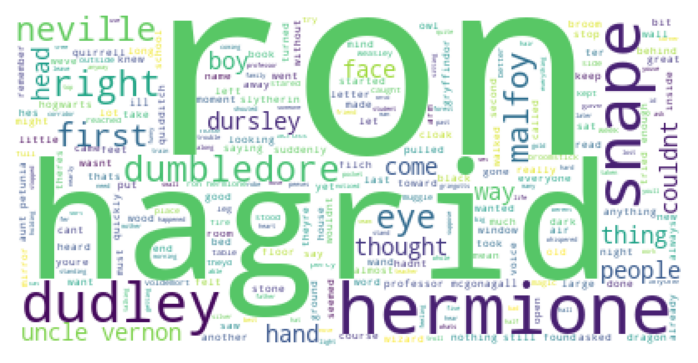


 Wordcloud for (Book II) Harry Potter and the Chamber of Secrets


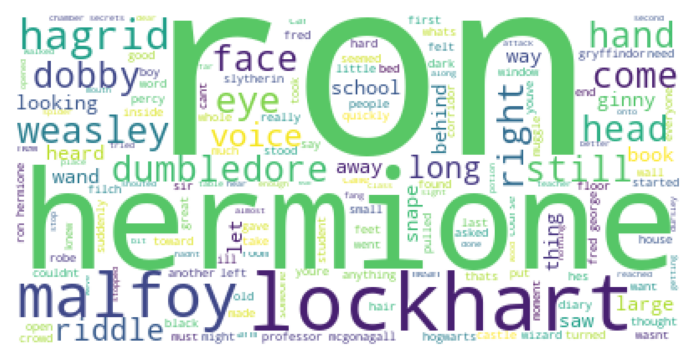


 Wordcloud for (Book III) Harry Potter and the Prisoner of Azkaban


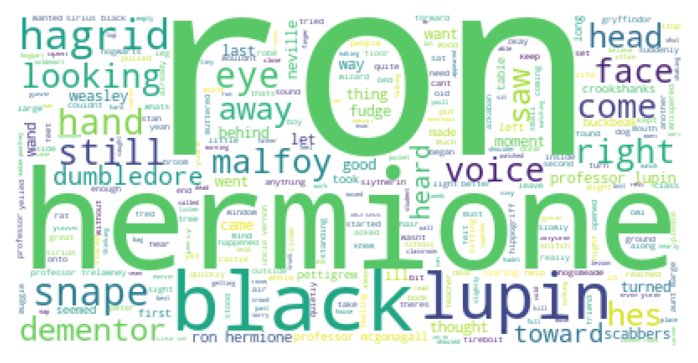


 Wordcloud for (Book IV) Harry Potter and the Goblet of Fire


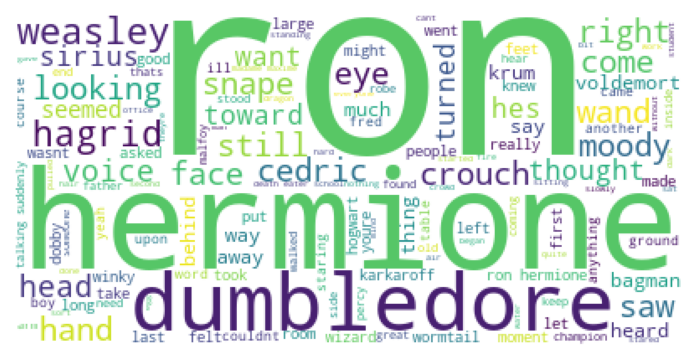


 Wordcloud for (Book V) Harry Potter and the Order of the Phoenix


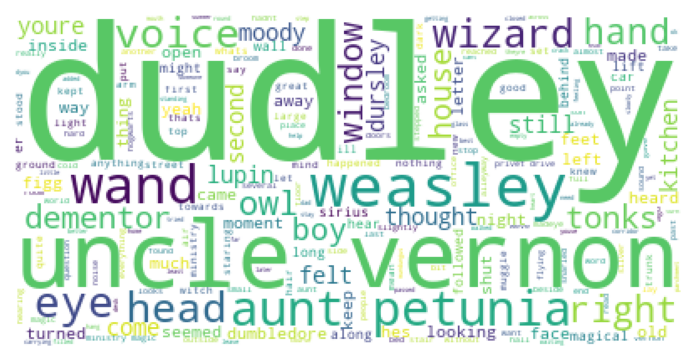


 Wordcloud for (Book VI) Harry Potter and the Half-Blood Prince


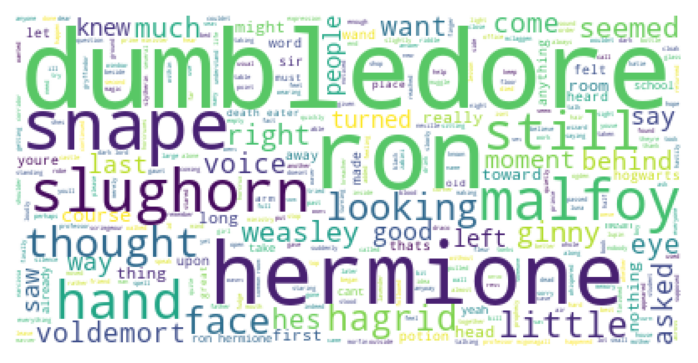


 Wordcloud for (Book VII) Harry Potter and the Deathly Hallows


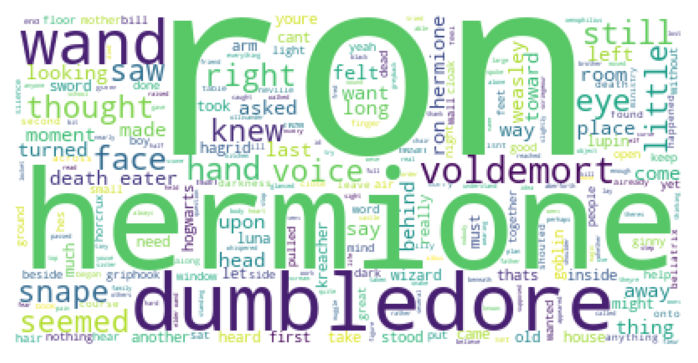

In [25]:
print('Wordcloud for',book1)
show_wordcloud(H1_clean)
print('\n Wordcloud for',book2)
show_wordcloud(H2_clean)
print('\n Wordcloud for',book3)
show_wordcloud(H3_clean)
print('\n Wordcloud for',book4)
show_wordcloud(H4_clean)
print('\n Wordcloud for',book5)
show_wordcloud(H5_clean)
print('\n Wordcloud for',book6)
show_wordcloud(H6_clean)
print('\n Wordcloud for',book7)
show_wordcloud(H7_clean)

#### Applying LDA to perform topic modelling on all the Harry Potter Books. 
#### Please refer to the html files in this repository to take a closer look at the topics and the keywords related to those topics. The html files are generated using the pyLDAvis library which is used to visualize the results of the LDA 

In [105]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(H1_clean)

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

# Keywords for topics clustered by Latent Dirichlet Allocation
print('##############THE 5 TOPICS FOR BOOK 1 ARE AS FOLLOWS###############')
print('\nLDA Model:')
selected_topics(lda, vectorizer)
# visualizing the results. An html interactive file will be created
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'LDA_Visualization1.html')

<>:1: DeprecationWarning: invalid escape sequence \-
<>:1: DeprecationWarning: invalid escape sequence \-
<ipython-input-105-8b3685b4b845>:1: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')


##############THE 5 TOPICS FOR BOOK 1 ARE AS FOLLOWS###############

LDA Model:
Topic 0:
[('right', 127.7950013880537), ('come', 101.53753614306345), ('head', 100.86405490230533), ('turned', 77.85478899492105), ('wasnt', 74.38776942313481), ('boy', 69.42809390244054), ('long', 66.81520558033382), ('voice', 62.29926560646637), ('wood', 55.31502628685677), ('slytherin', 52.78722173236256)]


Topic 1:
[('professor', 179.456747502407), ('dumbledore', 149.966715957311), ('stone', 98.8035567581346), ('good', 91.2743909099658), ('mcgonagall', 88.13175544022147), ('want', 77.72675959211084), ('hogwarts', 70.662142519804), ('bit', 65.40367663151267), ('cloak', 65.08321708149312), ('saw', 61.75379222029426)]


Topic 2:
[('hermione', 326.20376963077524), ('malfoy', 119.77067976976701), ('quirrell', 119.20119167029944), ('neville', 118.76807149364345), ('eyes', 99.30474362392765), ('gryffindor', 96.24973781150317), ('uncle', 88.80914313389928), ('vernon', 77.09115089814652), ('heard', 75.494684268

In [35]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(H2_clean)

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

# Keywords for topics clustered by Latent Dirichlet Allocation
print('##############THE 5 TOPICS FOR BOOK 2 ARE AS FOLLOWS###############')
print('\nLDA Model:')
selected_topics(lda, vectorizer)
# visualizing the results. An html interactive file will be created
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'LDA_Visualization2.html')

<>:1: DeprecationWarning: invalid escape sequence \-
<>:1: DeprecationWarning: invalid escape sequence \-
<ipython-input-35-b3177be6925a>:1: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')



LDA Model:
Topic 0:
[('wand', 119.87905970280654), ('way', 93.22296799289575), ('room', 92.68822191887504), ('floor', 82.90883384974005), ('gryffindor', 79.82691901676701), ('great', 63.86410722934055), ('nearly', 59.75038248240005), ('pulled', 57.57722189004754), ('little', 54.63786567449173), ('started', 51.78421092273191)]


Topic 1:
[('lockhart', 203.4597250992056), ('dobby', 125.21803381026079), ('ginny', 124.50173516629215), ('face', 121.85628677947248), ('voice', 120.54588496175671), ('looking', 119.51379068293008), ('long', 119.22394010591744), ('mcgonagall', 92.18254949126973), ('hogwarts', 82.96895011893878), ('thought', 81.4121694874006)]


Topic 2:
[('ron', 660.3844813188871), ('hermione', 284.85599454999465), ('malfoy', 208.34481362136927), ('away', 93.37364493017863), ('large', 88.6678597263651), ('snape', 82.60788583171829), ('youre', 64.85388948354749), ('thing', 61.65875859012872), ('black', 52.20686702473796), ('inside', 50.6124026510845)]


Topic 3:
[('eyes', 154.32

In [100]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(H3_clean)

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

# Keywords for topics clustered by Latent Dirichlet Allocation
print('##############THE 5 TOPICS FOR BOOK 3 ARE AS FOLLOWS###############')
print('\nLDA Model:')
selected_topics(lda, vectorizer)
# visualizing the results. An html interactive file will be created
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'LDA_Visualization3.html')

<>:1: DeprecationWarning: invalid escape sequence \-
<>:1: DeprecationWarning: invalid escape sequence \-
<ipython-input-100-a8a39a05568b>:1: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')



LDA Model:
Topic 0:
[('ron', 687.8065183036051), ('professor', 375.15605501799166), ('black', 364.64366242986625), ('eyes', 179.84607287554616), ('sirius', 172.37469485286633), ('looking', 152.51939428403375), ('turned', 118.50870356468107), ('room', 102.43238825975683), ('moment', 98.38610963075796), ('ill', 97.04883423123987)]


Topic 1:
[('hagrid', 207.20598393254542), ('dumbledore', 177.79536131997295), ('hes', 154.6893000843323), ('head', 142.05598876511402), ('malfoy', 136.67219508409156), ('hand', 113.59722876542659), ('dementors', 110.3874833348079), ('way', 103.5339587290395), ('inside', 85.50135689886297), ('neville', 79.58374140453427)]


Topic 2:
[('face', 170.15130904802143), ('voice', 135.63983167202937), ('heard', 128.1961730601106), ('buckbeak', 102.83399506293895), ('came', 95.96514070779861), ('took', 88.68046276502638), ('long', 86.60639775722032), ('hear', 81.04755860655204), ('cloak', 74.9584297181394), ('feet', 72.98483969973867)]


Topic 3:
[('snape', 230.737582

In [101]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(H4_clean)

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

# Keywords for topics clustered by Latent Dirichlet Allocation
print('##############THE 5 TOPICS FOR BOOK 4 ARE AS FOLLOWS###############')
print('\nLDA Model:')
selected_topics(lda, vectorizer)
# visualizing the results. An html interactive file will be created
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'LDA_Visualization4.html')

<>:1: DeprecationWarning: invalid escape sequence \-
<>:1: DeprecationWarning: invalid escape sequence \-
<ipython-input-101-7ab6392ce60b>:1: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')



LDA Model:
Topic 0:
[('hermione', 806.734161586731), ('weasley', 260.9246546359012), ('snape', 252.30316434583324), ('thought', 215.5975098553717), ('heard', 185.7028692863543), ('great', 169.41640873686723), ('knew', 163.33215329803855), ('death', 153.17739208463541), ('moment', 140.92550344928355), ('wormtail', 135.13595915089363)]


Topic 1:
[('face', 299.36663902486487), ('head', 243.70712617463082), ('dark', 203.51648067872856), ('room', 186.04465509231596), ('went', 158.00541962673378), ('hall', 151.76254111160685), ('feet', 146.38495453371723), ('took', 142.97138915613863), ('yeah', 139.46852468374905), ('george', 132.99179824683918)]


Topic 2:
[('moody', 333.86975768553816), ('wand', 308.50661427558066), ('professor', 291.17913858567056), ('cedric', 277.89992510683487), ('come', 263.6710550919641), ('krum', 202.84702785025567), ('turned', 201.60064658423525), ('long', 171.59390887180226), ('felt', 170.930205317006), ('table', 164.08726766070646)]


Topic 3:
[('ron', 922.55728

In [102]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(H5_clean)

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

# Keywords for topics clustered by Latent Dirichlet Allocation
print('##############THE 5 TOPICS FOR BOOK 5 ARE AS FOLLOWS###############')
print('\nLDA Model:')
selected_topics(lda, vectorizer)
# visualizing the results. An html interactive file will be created
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'LDA_Visualization5.html')

<>:1: DeprecationWarning: invalid escape sequence \-
<>:1: DeprecationWarning: invalid escape sequence \-
<ipython-input-102-7393333cdd9e>:1: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')



LDA Model:
Topic 0:
[('weasley', 87.96638492504673), ('days', 65.4404972061314), ('wand', 62.3690217411067), ('come', 28.383863502718), ('house', 28.173294659022815), ('kitchen', 28.09713992371839), ('old', 24.0193935999174), ('second', 19.93415045368929), ('came', 19.72512210458626), ('followed', 19.62232980894113)]


Topic 1:
[('uncle', 80.86933557472983), ('dudley', 71.95816076292468), ('lupin', 31.805811034934766), ('eyes', 31.271142448304644), ('moody', 29.782550003671016), ('magical', 28.18786221709783), ('youre', 26.249508728602272), ('left', 25.850522086601423), ('wizards', 22.23832022570372), ('window', 20.920955668835546)]


Topic 2:
[('vernon', 70.9851902980175), ('voice', 42.876597038974445), ('wizard', 31.348085263119707), ('felt', 27.220669027817348), ('open', 24.671999839462604), ('moment', 20.26722262189655), ('night', 20.249230342821303), ('doors', 19.714961151550963), ('feet', 19.262207812098396), ('hes', 19.22066775853738)]


Topic 3:
[('yeah', 90.91067659946246), (

In [103]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(H6_clean)

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

# Keywords for topics clustered by Latent Dirichlet Allocation
print('##############THE 5 TOPICS FOR BOOK 6 ARE AS FOLLOWS###############')
print('\nLDA Model:')
selected_topics(lda, vectorizer)
# visualizing the results. An html interactive file will be created
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'LDA_Visualization6.html')

<>:1: DeprecationWarning: invalid escape sequence \-
<>:1: DeprecationWarning: invalid escape sequence \-
<ipython-input-103-32a030094a29>:1: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')



LDA Model:
Topic 0:
[('ron', 781.0639878258086), ('hermione', 633.4756373039472), ('snape', 370.23311638666524), ('looking', 242.89755730154207), ('ginny', 232.04952774113738), ('hagrid', 219.2348782584102), ('saw', 204.0598424637116), ('voice', 201.66017251468986), ('feet', 111.5420808858652), ('mean', 104.42967866390707)]


Topic 1:
[('malfoy', 348.45046649462046), ('eyes', 211.54618862793473), ('want', 180.6788517173721), ('death', 166.91990852929564), ('moment', 162.48725679668206), ('hogwarts', 138.99408608811189), ('great', 130.2964173552449), ('felt', 130.08844052397004), ('old', 111.14001383778903), ('ill', 99.60813854842245)]


Topic 2:
[('voldemort', 238.6868976035762), ('come', 194.1156075798477), ('knew', 183.39146835908008), ('hes', 176.56377040111164), ('people', 165.99331314557577), ('turned', 158.17655337017433), ('left', 153.0223467252337), ('youre', 128.7717004518574), ('thats', 126.88529244558772), ('school', 123.98152543765293)]


Topic 3:
[('dumbledore', 971.94561

In [104]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(H7_clean)

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online',verbose=False)
data_lda = lda.fit_transform(data_vectorized)

# Keywords for topics clustered by Latent Dirichlet Allocation
print('##############THE 5 TOPICS FOR BOOK 7 ARE AS FOLLOWS###############')
print('\nLDA Model:')
selected_topics(lda, vectorizer)
# visualizing the results. An html interactive file will be created
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(dash, 'LDA_Visualization7.html')

<>:1: DeprecationWarning: invalid escape sequence \-
<>:1: DeprecationWarning: invalid escape sequence \-
<ipython-input-104-5a7f62e3ab0e>:1: DeprecationWarning: invalid escape sequence \-
  vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')



LDA Model:
Topic 0:
[('dark', 191.0913683955458), ('old', 153.13449923266273), ('feet', 130.6093225189068), ('boy', 127.05516922232334), ('thing', 126.8118133805274), ('hall', 118.14612050810796), ('pulled', 114.45241602379858), ('help', 112.79335830759572), ('dumbledores', 107.42584518524784), ('magic', 104.8688764568417)]


Topic 1:
[('snape', 329.58973831553266), ('asked', 263.4909295246314), ('away', 242.10703875878616), ('left', 185.04905616392327), ('place', 171.70971953126963), ('want', 165.63205444164504), ('stood', 163.86843282050836), ('air', 159.05819439039567), ('inside', 143.8968109868589), ('open', 134.61288802432827)]


Topic 2:
[('hermione', 1015.1044798987929), ('knew', 286.59363782331025), ('room', 248.60406124376144), ('looking', 224.35193585615139), ('way', 222.46629772541633), ('come', 222.34973532249387), ('turned', 194.52753334766177), ('cloak', 194.12771865130534), ('long', 190.6016520278179), ('heard', 171.75973794004946)]


Topic 3:
[('ron', 991.2088131615058

### Further analysis was done using Gephi. Gephi was used to perform network analysis on Book 1 which highlights the important parts/characters in the book. Please refer to the .net files and the .pdf report in this repository for the network diagram. 

### Gephi is the leading visualization and exploration software for all kinds of graphs and networks. Gephi is open-source and free. You can open the .net files in Gephi. 

### Link to download Gephi, it is a free, open-source and a very powerful exploration software - https://gephi.org